# Household Consumption
## In this Jupyter Notebook, we will analyze and forecast household consumption

# 1) Data cleaning and data visualization

In [30]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
# The code was removed by Watson Studio for sharing.

,Unnamed: 0,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,,
2006-12-16 17:24:00,0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## Data cleaning

In [32]:
df_hc.replace('?',np.NaN,inplace=True)
df_hc[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1',
       'Sub_metering_2','Sub_metering_3']] = \
df_hc[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1',
       'Sub_metering_2','Sub_metering_3']].astype(float)
df_hc.dtypes
df_hc.drop(columns=['Unnamed: 0'],inplace=True)
df_hc['Sub_metering_4'] = df_hc['Global_active_power']*(1000/60)  - \
                         (df_hc['Sub_metering_1'] + df_hc['Sub_metering_2'] + df_hc['Sub_metering_3'])

In [33]:
df_hc_24H = df_hc.asfreq(freq='24H')
df_hc_24H.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-17 17:24:00,3.390,0.170,232.65,14.6,0.0,0.0,17.0,39.500000
2006-12-18 17:24:00,1.956,0.000,239.57,8.0,0.0,0.0,18.0,14.600000
2006-12-19 17:24:00,1.446,0.000,240.51,6.0,0.0,0.0,17.0,7.100000
2006-12-20 17:24:00,0.430,0.126,244.48,1.8,0.0,0.0,0.0,7.166667


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fefe7614400>,
      dtype=object)

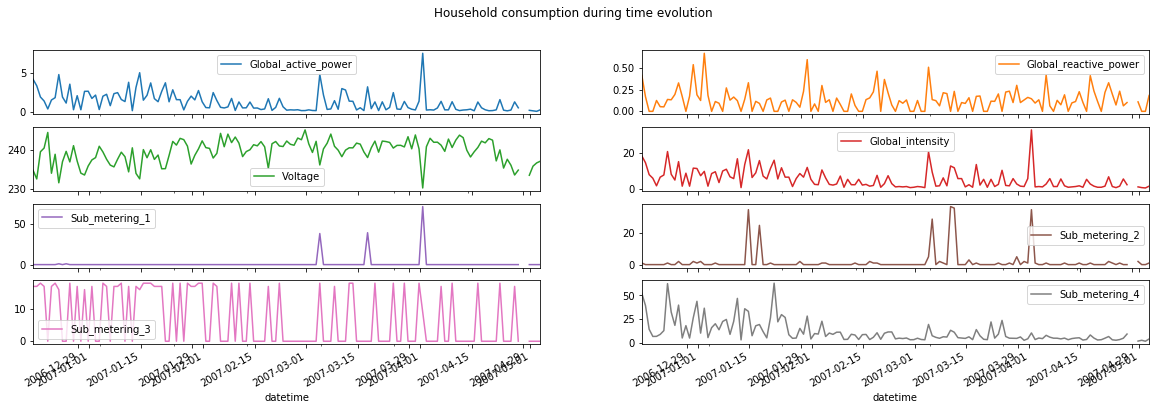

In [34]:
df_hc_24H.plot(subplots=True,layout=(4,2),title='Household consumption during time evolution',figsize=(20, 6))

# Forcasting of the consumption in each room according to the global consumption

## Correlation analysis

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


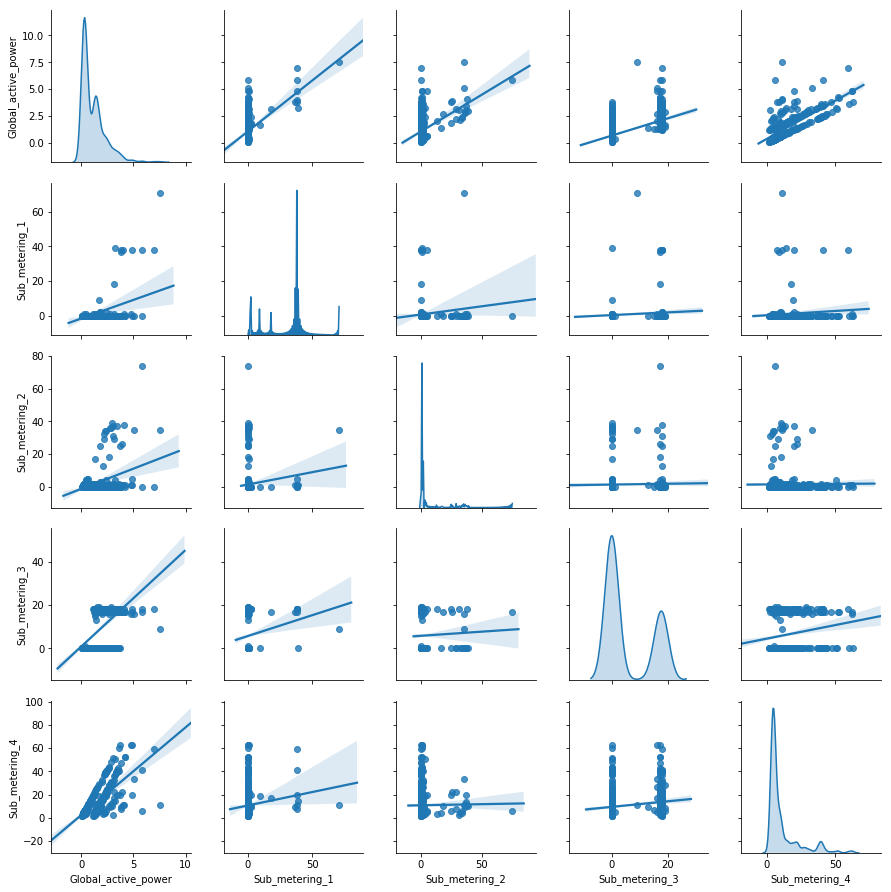

In [35]:
sns.pairplot(df_hc.asfreq(freq='6H').drop(columns=['Global_reactive_power','Voltage','Global_intensity']),
                                     kind="reg",diag_kind="kde")

Text(0.5, 1.0, 'Pearson Correlation Matrix')

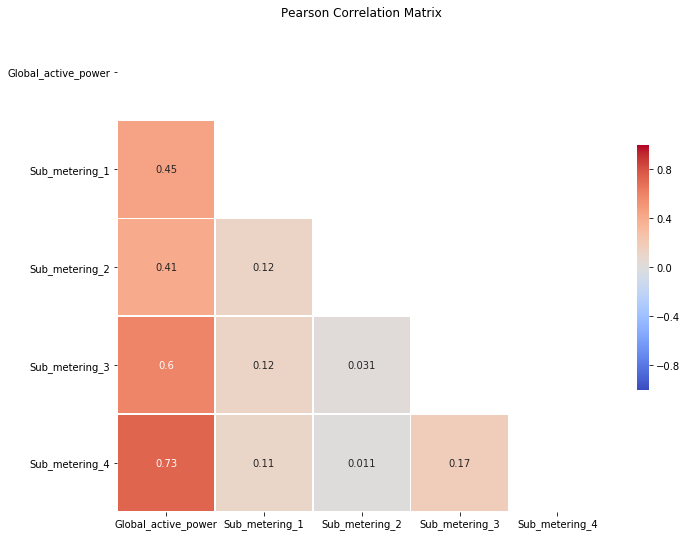

In [36]:
# Compute the correlation matrix
corr = df_hc.asfreq(freq='6H').drop(columns=['Global_reactive_power','Voltage','Global_intensity']).corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = plt.axes()
sns.heatmap(corr, cmap='coolwarm', mask=mask, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True,ax=ax)
ax.set_title('Pearson Correlation Matrix')

## Choosing the sample method and coefficient

Optimal sample frequency is  1730 hours with " sum " sampling method
Correlation are [0.63622872 0.55748396 0.77530189 0.93727517]


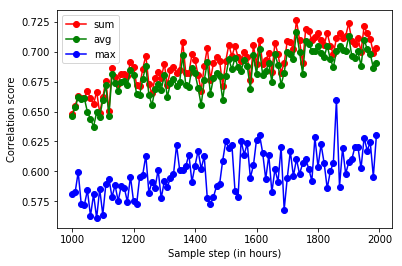

In [48]:
sample_freq_range = range(1000,2000,10)
corr_scores_sum = []
corr_scores_mean = []
corr_scores_max = []
for sample_freq in sample_freq_range:
    corr_sum = np.abs(df_hc.drop(columns=['Global_reactive_power','Voltage','Global_intensity']) \
                        .fillna(method='backfill').resample(str(sample_freq)+'T').sum().corr().values[1:,0]).sum()/4
    
    corr_mean = np.abs(df_hc.drop(columns=['Global_reactive_power','Voltage','Global_intensity']) \
                        .fillna(method='backfill').resample(str(sample_freq)+'T').mean().corr().values[1:,0]).sum()/4
    
    corr_max = np.abs(df_hc.drop(columns=['Global_reactive_power','Voltage','Global_intensity']) \
                        .fillna(method='backfill').resample(str(sample_freq)+'T').max().corr().values[1:,0]).sum()/4
    
    corr_scores_sum.append(corr_sum)
    corr_scores_mean.append(corr_mean)
    corr_scores_min.append(corr_min)
    corr_scores_max.append(corr_max)

Method = ['sum','avg','max']
    
plt.plot(sample_freq_range,corr_scores_sum,'-o',color='r',label='sum')
plt.plot(sample_freq_range,corr_scores_mean,'-o',color='g',label='avg')
plt.plot(sample_freq_range,corr_scores_max,'-o',color='b',label='max')
plt.xlabel('Sample step (in hours)')
plt.ylabel('Correlation score')
plt.legend()
print('Optimal sample frequency is ',sample_freq_range[np.argmax(corr_scores_sum)],'hours with'
      ,'"',Method[np.argmax([max(corr_scores_sum),max(corr_scores_mean),max(corr_scores_max)])],'"',
      'sampling method')
print('Correlation are',df_hc.drop(columns=['Global_reactive_power','Voltage','Global_intensity']) \
                        .fillna(method='backfill').resample(str(sample_freq_range[np.argmax(corr_scores_sum)])+'T').sum().corr().values[1:,0])

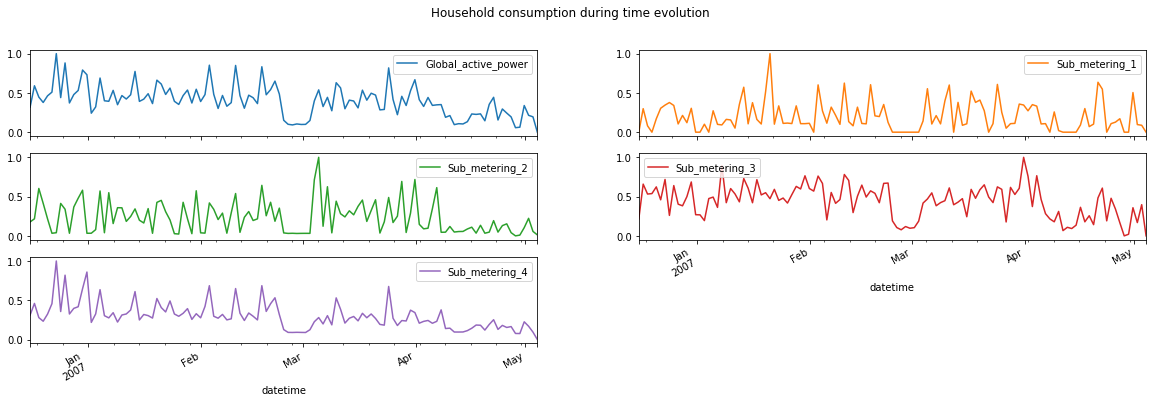

In [49]:
from sklearn import preprocessing

x = df_hc.drop(columns=['Global_reactive_power','Voltage','Global_intensity']) \
                        .fillna(method='backfill').resample(str(sample_freq_range[np.argmax(corr_scores_sum)])+'T').sum().values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_hc_scaled = pd.DataFrame(x_scaled,columns=['Global_active_power','Sub_metering_1',
       'Sub_metering_2','Sub_metering_3','Sub_metering_4'], index=df_hc.drop(columns=['Global_reactive_power','Voltage','Global_intensity']) \
                        .fillna(method='backfill').resample(str(sample_freq_range[np.argmax(corr_scores_sum)])+'T').sum().index)
df_hc_scaled.plot(subplots=True,layout=(3,2),title='Household consumption during time evolution',figsize=(20, 6))

X = df_hc_scaled['Global_active_power'].values.reshape(-1, 1)
y = df_hc_scaled[['Sub_metering_1',
       'Sub_metering_2','Sub_metering_3','Sub_metering_4']].values

## Linear Regression

MSE for Linear Regression : 0.031153881429483585


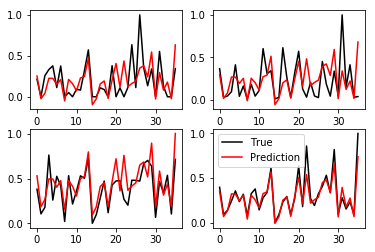

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = LinearRegression().fit(X_train, y_train)
yhat = clf.predict(X_test)
mse_lr = mean_squared_error(y_test, yhat)
print('MSE for Linear Regression :',mse_lr)

plt.subplot(2,2,1)
plt.plot(y_test[:,0],'-',color='k',label='True')
plt.plot(yhat[:,0],'-',color='r',label='Prediction')
plt.subplot(2,2,2)
plt.plot(y_test[:,1],'-',color='k',label='True')
plt.plot(yhat[:,1],'-',color='r',label='Prediction')
plt.subplot(2,2,3)
plt.plot(y_test[:,2],'-',color='k',label='True')
plt.plot(yhat[:,2],'-',color='r',label='Prediction')
plt.subplot(2,2,4)
plt.plot(y_test[:,3],'-',color='k',label='True')
plt.plot(yhat[:,3],'-',color='r',label='Prediction')
plt.legend()

## Support Vector Machine

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


MSE for SVM Regression : 0.028943187008540736


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


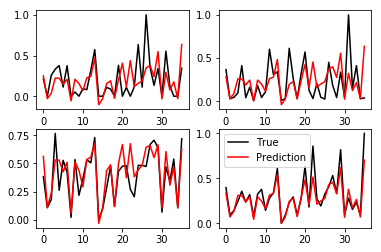

In [51]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

parameters = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C':[0.01, 0.1, 1, 10]}
svr = SVR(gamma='auto')
clf = GridSearchCV(svr, parameters,cv=4)
clf.fit(X_train, y_train[:,2])
print(clf.best_estimator_)

msvr = MultiOutputRegressor(clf)
msvr.fit(X_train, y_train)

yhat = msvr.predict(X_test)
mse_svr = mean_squared_error(y_test, yhat)
print('MSE for SVM Regression :',mse_svr)

plt.subplot(2,2,1)
plt.plot(y_test[:,0],'-',color='k',label='True')
plt.plot(yhat[:,0],'-',color='r',label='Prediction')
plt.subplot(2,2,2)
plt.plot(y_test[:,1],'-',color='k',label='True')
plt.plot(yhat[:,1],'-',color='r',label='Prediction')
plt.subplot(2,2,3)
plt.plot(y_test[:,2],'-',color='k',label='True')
plt.plot(yhat[:,2],'-',color='r',label='Prediction')
plt.subplot(2,2,4)
plt.plot(y_test[:,3],'-',color='k',label='True')
plt.plot(yhat[:,3],'-',color='r',label='Prediction')
plt.legend()

## Decision Tree

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


DecisionTreeRegressor(criterion='mae', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


MSE for SVM Regression : 0.02876915246784332


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


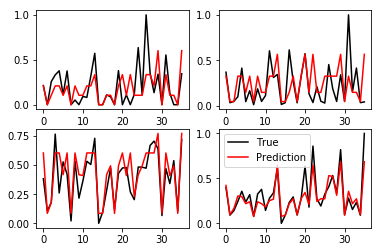

In [52]:
from sklearn.tree import DecisionTreeRegressor

parameters = {'criterion':('mse', 'friedman_mse','mae'), 'max_depth':range(1,15)}
dt = DecisionTreeRegressor(random_state=0)
clf = GridSearchCV(dt, parameters,cv=4)
clf.fit(X_train, y_train[:,2])
print(clf.best_estimator_)

mdt = MultiOutputRegressor(clf)
mdt.fit(X_train, y_train)

yhat = mdt.predict(X_test)
mse_dt = mean_squared_error(y_test, yhat)
print('MSE for SVM Regression :',mse_dt)

plt.subplot(2,2,1)
plt.plot(y_test[:,0],'-',color='k',label='True')
plt.plot(yhat[:,0],'-',color='r',label='Prediction')
plt.subplot(2,2,2)
plt.plot(y_test[:,1],'-',color='k',label='True')
plt.plot(yhat[:,1],'-',color='r',label='Prediction')
plt.subplot(2,2,3)
plt.plot(y_test[:,2],'-',color='k',label='True')
plt.plot(yhat[:,2],'-',color='r',label='Prediction')
plt.subplot(2,2,4)
plt.plot(y_test[:,3],'-',color='k',label='True')
plt.plot(yhat[:,3],'-',color='r',label='Prediction')
plt.legend()

## Neural Network

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=20, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=1e-12,
       validation_fraction=0.1, verbose=0, warm_start=False)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


MSE for SVM Regression : 0.02846918033601267


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


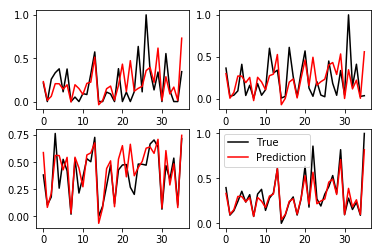

In [55]:
from sklearn.neural_network import MLPRegressor

parameters = {'hidden_layer_sizes': range(1,50)}
ANN = MLPRegressor(solver="lbfgs",activation='relu',tol=1e-12,max_iter=1200
                    ,learning_rate = "adaptive",verbose=0)
clf = GridSearchCV(ANN, parameters,cv=4)
clf.fit(X_train, y_train[:,2])
print(clf.best_estimator_)

mANN = MultiOutputRegressor(clf)
mANN.fit(X_train, y_train)

yhat = mANN.predict(X_test)
mse_ANN = mean_squared_error(y_test, yhat)
print('MSE for SVM Regression :',mse_ANN)

plt.subplot(2,2,1)
plt.plot(y_test[:,0],'-',color='k',label='True')
plt.plot(yhat[:,0],'-',color='r',label='Prediction')
plt.subplot(2,2,2)
plt.plot(y_test[:,1],'-',color='k',label='True')
plt.plot(yhat[:,1],'-',color='r',label='Prediction')
plt.subplot(2,2,3)
plt.plot(y_test[:,2],'-',color='k',label='True')
plt.plot(yhat[:,2],'-',color='r',label='Prediction')
plt.subplot(2,2,4)
plt.plot(y_test[:,3],'-',color='k',label='True')
plt.plot(yhat[:,3],'-',color='r',label='Prediction')
plt.legend()

## Summary

In [56]:
t = {'Linear Regression':round(mse_lr,5),'SVM Regression':round(mse_svr,5),'Decision Tree Regression':round(mse_dt,5),'Neural Network':round(mse_ANN,5)}
df = pd.Series(t)
df.sort_values()

Neural Network              0.02847
Decision Tree Regression    0.02877
SVM Regression              0.02894
Linear Regression           0.03115
dtype: float64

# Global active power forecasting

## ARIMA model

Text(0.5, 1.0, 'Rolling Mean & Rolling Standard Deviation')

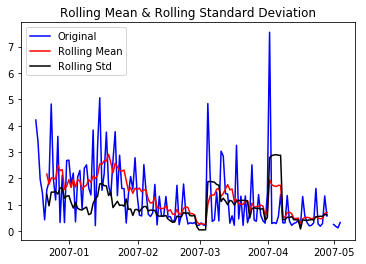

In [57]:
window = 6

rolling_mean = df_hc_24H.rolling(window = window).mean()
rolling_std = df_hc_24H.rolling(window = window).std()

plt.plot(df_hc_24H['Global_active_power'], color = 'blue', label = 'Original')
plt.plot(rolling_mean['Global_active_power'], color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std['Global_active_power'], color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')

In [58]:
from statsmodels.tsa.arima_model import ARIMA
series = rolling_mean['Global_active_power'][window:-window]
print(series)
model = ARIMA(series, order=(1,1,0))
model_fit = model.fit(disp=0)

datetime
2006-12-22 17:24:00    1.778000
2006-12-23 17:24:00    2.017000
2006-12-24 17:24:00    2.017000
2006-12-25 17:24:00    1.973000
2006-12-26 17:24:00    2.500667
2006-12-27 17:24:00    2.293000
2006-12-28 17:24:00    2.335000
2006-12-29 17:24:00    1.585000
2006-12-30 17:24:00    1.705667
2006-12-31 17:24:00    1.957667
2007-01-01 17:24:00    1.654000
2007-01-02 17:24:00    1.966333
2007-01-03 17:24:00    1.671000
2007-01-04 17:24:00    1.960000
2007-01-05 17:24:00    1.897333
2007-01-06 17:24:00    1.589333
2007-01-07 17:24:00    1.691333
2007-01-08 17:24:00    1.743333
2007-01-09 17:24:00    1.957333
2007-01-10 17:24:00    1.843333
2007-01-11 17:24:00    2.099000
2007-01-12 17:24:00    1.992667
2007-01-13 17:24:00    2.126333
2007-01-14 17:24:00    2.551000
2007-01-15 17:24:00    2.536667
2007-01-16 17:24:00    2.670333
2007-01-17 17:24:00    2.656667
2007-01-18 17:24:00    2.913333
2007-01-19 17:24:00    2.608000
2007-01-20 17:24:00    2.211000
                         ...   

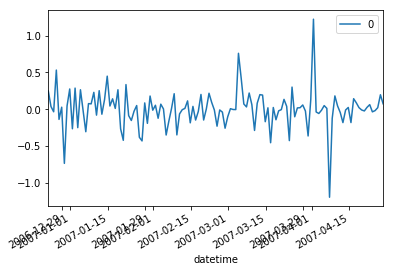

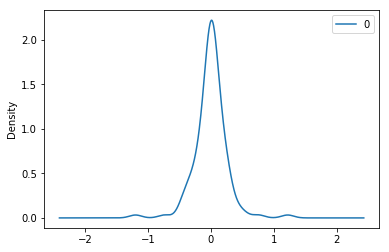

In [59]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')

In [60]:
from sklearn.metrics import mean_squared_error
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []
for t in range(len(df_hc_24H[col])):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
error = mean_squared_error(test, predictions[size:len(X)])
print('Test MSE: %.3f' % error)
plt.plot(test)
plt.plot(predictions, color='red')

NameError: name 'col' is not defined

# Time step anomaly detection

## Anomaly dectection using DBSCAN

On analyse 6542 instants


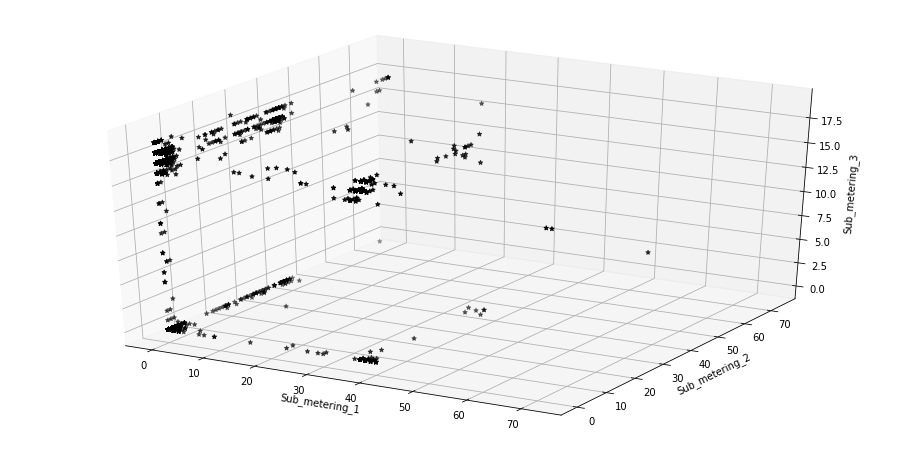

In [58]:
from mpl_toolkits.mplot3d import Axes3D 

df_hc_freq = df_hc.asfreq(freq='30T')
df_hc_skipna = df_hc_freq[(~df_hc_freq['Sub_metering_1'].isnull()) & (~df_hc_freq['Sub_metering_2'].isnull()) & (~df_hc_freq['Sub_metering_2'].isnull())]  \
[['Sub_metering_1','Sub_metering_2','Sub_metering_3']]

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d',)

ax.scatter(df_hc_skipna['Sub_metering_1'],df_hc_skipna['Sub_metering_2'],df_hc_skipna['Sub_metering_3'],c='k', marker='*')
ax.set_xlabel('Sub_metering_1')
ax.set_ylabel('Sub_metering_2')
ax.set_zlabel('Sub_metering_3')

print('On analyse',df_hc_skipna.shape[0],'instants')

In [59]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X = df_hc_skipna[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].values
X = StandardScaler().fit_transform(X)

outlier_detection = DBSCAN(
  eps = 0.5,
  metric="euclidean",
  min_samples = 3,
  n_jobs = -1)
clusters = outlier_detection.fit_predict(X)

Text(0.5, 0, 'Sub_metering_3')

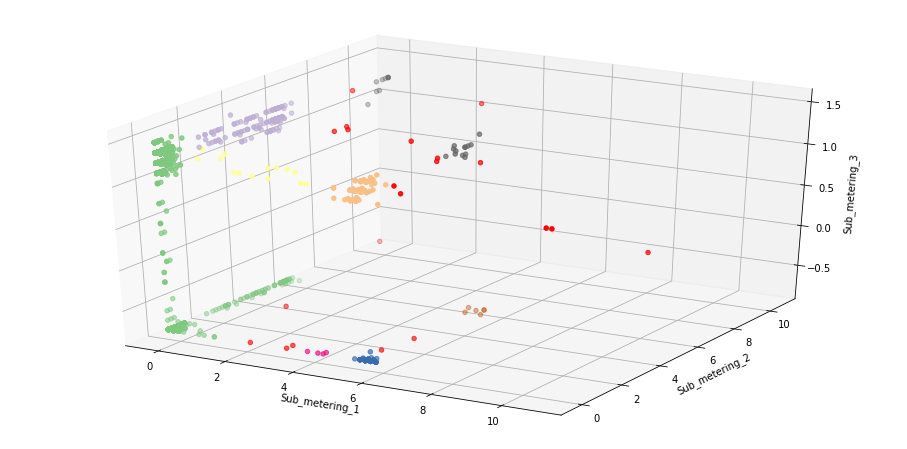

In [60]:
from matplotlib import cm

cmap = cm.get_cmap('Accent')

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
  xs = X[clusters>-1,0],
  ys = X[clusters>-1,1],
  zs = X[clusters>-1,2],
  c = clusters[clusters>-1],
  cmap = cmap,
)

ax.scatter(
  xs = X[clusters<0,0],
  ys = X[clusters<0,1],
  zs = X[clusters<0,2],
  c = 'r'
 # c = clusters,
#  cmap = cmap,
)
ax.set_xlabel('Sub_metering_1')
ax.set_ylabel('Sub_metering_2')
ax.set_zlabel('Sub_metering_3')

In [61]:
clusters_dbscan = clusters
print('Il y a',round(100*(np.sum(clusters==-1)/df_hc_skipna.shape[0]),1),'% de temps anormaux, qui sont')
pd.DataFrame(df_hc_skipna.index[clusters==-1]).rename(columns={'datetime':'Anomaly date-time'})

Il y a 0.3 % de temps anormaux, qui sont


,Anomaly date-time
0,2006-12-19 08:54:00
1,2006-12-25 21:54:00
2,2006-12-29 21:24:00
3,2007-01-13 22:54:00
4,2007-01-17 10:24:00
5,2007-01-20 10:24:00
6,2007-01-21 15:24:00
7,2007-01-21 20:54:00
8,2007-01-21 21:24:00
9,2007-01-21 21:54:00


## Anomaly detection using Isolation Forest

In [62]:
from sklearn.ensemble import IsolationForest

outlier_detection = IsolationForest(random_state=0,n_jobs=-1)
clusters = outlier_detection.fit_predict(X)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Text(0.5, 0, 'Sub_metering_3')

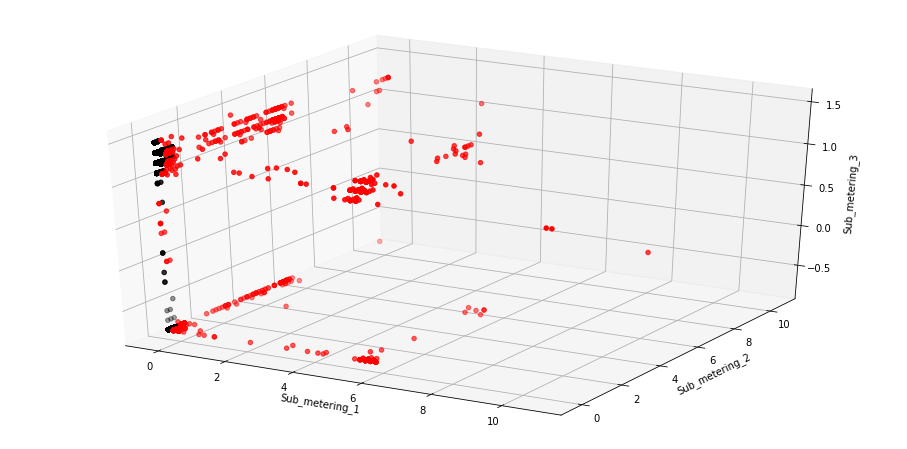

In [66]:
fig2 = plt.figure(figsize=(16, 8))
ax = fig2.add_subplot(111, projection='3d')

ax.scatter(
  xs = X[clusters>0,0],
  ys = X[clusters>0,1],
  zs = X[clusters>0,2],
  c = 'k',
)

ax.scatter(
  xs = X[clusters<0,0],
  ys = X[clusters<0,1],
  zs = X[clusters<0,2],
  c = 'r'
)
ax.set_xlabel('Sub_metering_1')
ax.set_ylabel('Sub_metering_2')
ax.set_zlabel('Sub_metering_3')

In [67]:
clusters_IF = clusters
print('Il y a',round(100*(np.sum(clusters==-1)/df_hc_skipna.shape[0]),1),'% de temps anormaux, qui sont')
pd.DataFrame(df_hc_skipna.index[clusters==-1]).rename(columns={'datetime':'Anomaly date-time'})

Il y a 9.7 % de temps anormaux, qui sont


,Anomaly date-time
0,2006-12-17 01:24:00
1,2006-12-17 01:54:00
2,2006-12-17 10:24:00
3,2006-12-17 10:54:00
4,2006-12-17 11:24:00
5,2006-12-17 16:24:00
6,2006-12-18 08:54:00
7,2006-12-18 19:24:00
8,2006-12-18 19:54:00
9,2006-12-18 22:54:00


## Anomaly detection using Local Outlier Factor

In [68]:
from sklearn.neighbors import LocalOutlierFactor

outlier_detection = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski',
                                       p=2, metric_params=None, contamination='auto', novelty=False, n_jobs=None)
clusters = outlier_detection.fit_predict(X)

Text(0.5, 0, 'Sub_metering_3')

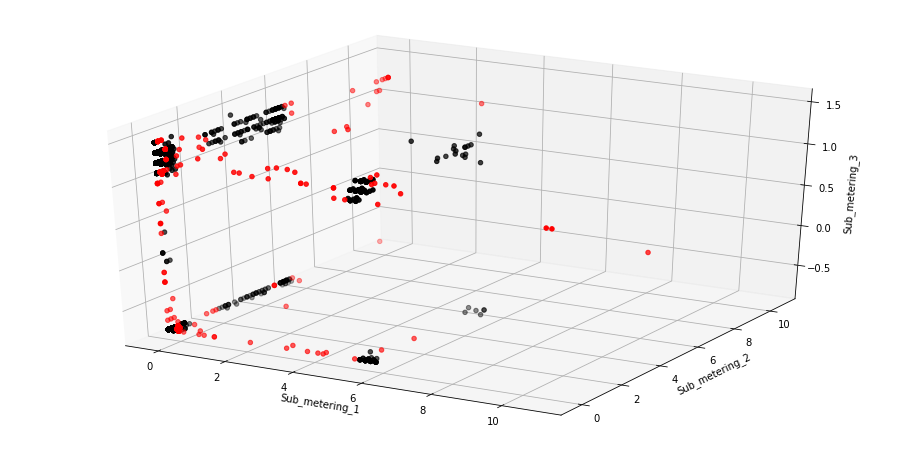

In [69]:
fig2 = plt.figure(figsize=(16, 8))
ax = fig2.add_subplot(111, projection='3d')

ax.scatter(
  xs = X[clusters>0,0],
  ys = X[clusters>0,1],
  zs = X[clusters>0,2],
  c = 'k',
)

ax.scatter(
  xs = X[clusters<0,0],
  ys = X[clusters<0,1],
  zs = X[clusters<0,2],
  c = 'r'
)
ax.set_xlabel('Sub_metering_1')
ax.set_ylabel('Sub_metering_2')
ax.set_zlabel('Sub_metering_3')

In [70]:
clusters_LOF = clusters
print('Il y a',round(100*(np.sum(clusters==-1)/df_hc_skipna.shape[0]),1),'% de temps anormaux, qui sont')
pd.DataFrame(df_hc_skipna.index[clusters==-1]).rename(columns={'datetime':'Anomaly date-time'})

Il y a 2.9 % de temps anormaux, qui sont


,Anomaly date-time
0,2006-12-16 18:54:00
1,2006-12-18 08:54:00
2,2006-12-18 23:24:00
3,2006-12-19 00:54:00
4,2006-12-19 08:54:00
5,2006-12-19 09:24:00
6,2006-12-19 11:24:00
7,2006-12-19 15:54:00
8,2006-12-20 14:54:00
9,2006-12-22 11:54:00


## Summary

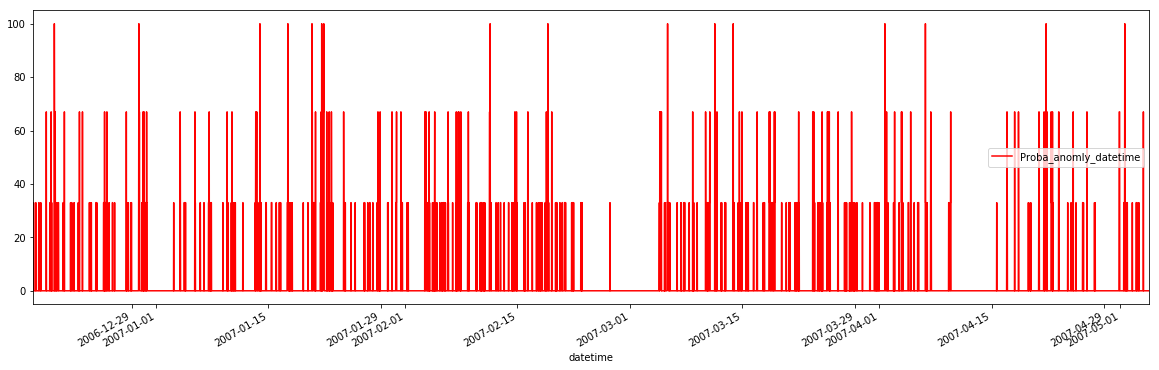

In [71]:

anomaly_detection = pd.DataFrame(np.asarray(clusters_dbscan==-1,dtype=int)+np.asarray(clusters_IF==-1,dtype=int)+np.asarray(clusters_LOF==-1,dtype=int),
                             index=df_hc_skipna.index,columns=['Proba_anomly_datetime'])
anomaly_detection['Proba_anomly_datetime'] = round(anomaly_detection['Proba_anomly_datetime']*(100/3),0)

anomaly_detection.plot(figsize=(20, 6),color='r')